In [ ]:
from google.colab import files


uploaded = files.upload()

Saving foodhub_order.csv to foodhub_order.csv


# Creating the Clickstream (The Simulation)
In a real company , every click is tracked. Since we only have the final orders, we are going to write a Python script to "reverse-engineer" the behavior of users who didn't buy anything. This makes your project realistic.

**The Logic:**
We will assume a standard industry conversion rate:

**App Open:** 100% of users.

**View Restaurant:** ~60% of people who opened the app.

**Add to Cart:** ~40% of people who viewed a restaurant.

**Order Placed:** The actual data you just downloaded.

In [ ]:
import pandas as pd
import numpy as np
import io


# 1. Load your downloaded data
df = pd.read_csv(io.BytesIO(uploaded['foodhub_order.csv']))
print(df)

      order_id  customer_id                        restaurant_name  \
0      1477147       337525                                Hangawi   
1      1477685       358141              Blue Ribbon Sushi Izakaya   
2      1477070        66393                            Cafe Habana   
3      1477334       106968              Blue Ribbon Fried Chicken   
4      1478249        76942                       Dirty Bird to Go   
...        ...          ...                                    ...   
1893   1476701       292602  Chipotle Mexican Grill $1.99 Delivery   
1894   1477421       397537                              The Smile   
1895   1477819        35309                      Blue Ribbon Sushi   
1896   1477513        64151                      Jack's Wife Freda   
1897   1478056       120353                      Blue Ribbon Sushi   

       cuisine_type  cost_of_the_order day_of_the_week     rating  \
0            Korean              30.75         Weekend  Not given   
1          Japanese  

In [ ]:
# 2. Let's pretend for every 1 order, 5 people opened the app but didn't buy
num_orders = len(df)
num_total_sessions = num_orders * 5

In [ ]:
# 3. Create a synthetic "Event Log"
events = []

for i in range(num_total_sessions):
    user_id = f"user_{np.random.randint(1000, 9999)}"

    # Everyone Opens the App
    events.append([user_id, 'app_open'])

    # 60% chance they View a Restaurant
    if np.random.random() < 0.60:
        events.append([user_id, 'view_restaurant'])

        # 40% chance they Add to Cart
        if np.random.random() < 0.40:
            events.append([user_id, 'add_to_cart'])

            # 20% chance they actually Place Order (Match this to your real data later)
            if np.random.random() < 0.20:
                events.append([user_id, 'order_placed'])

In [ ]:
# 4. Save this as your "Clickstream" data
activity_log = pd.DataFrame(events, columns=['user_id', 'event_name'])
activity_log.to_csv('activity_log.csv', index=False)

print(f"Generated {len(activity_log)} events. You now have a funnel!")

Generated 17950 events. You now have a funnel!


## Now we need to calculate the Conversion Rates.
In the industry, we don't just want the total counts; we want to know the "Throughput"—what percentage of people survived from one stage to the next.

The Goal:
Transform that long list of 17,950 rows into a clean summary table that looks like this:

Stage | Total Users | % of Previous Stage | % of Total Drop-off

In [ ]:
# Create a summary of the funnel
funnel_counts = activity_log['event_name'].value_counts().reindex([
    'app_open',
    'view_restaurant',
    'add_to_cart',
    'order_placed'
]).reset_index()

funnel_counts.columns = ['stage', 'user_count']

# Calculate the Conversion Rate (%)
# How many people stayed from the very beginning?
funnel_counts['conversion_rate'] = (funnel_counts['user_count'] / funnel_counts['user_count'].iloc[0] * 100).round(2)

# Calculate the Drop-off Rate (%)
# How many people did we lose at THIS specific step?
funnel_counts['drop_off_rate'] = (100 - (funnel_counts['user_count'] / funnel_counts['user_count'].shift(1) * 100)).round(2)
funnel_counts.fillna(0, inplace=True) # Fill the first row drop-off which is 0

print(funnel_counts)

             stage  user_count  conversion_rate  drop_off_rate
0         app_open        9490           100.00           0.00
1  view_restaurant        5722            60.30          39.70
2      add_to_cart        2271            23.93          60.31
3     order_placed         467             4.92          79.44


## The Hypothesis:
In food delivery, the top 3 reasons for checkout drop-off are:
1. High Delivery Cost: The burger was ₹200, but the total became ₹350.
2. Long ETA: The user is hungry now, but the app says 60 minutes.
3. Low Rating: They saw the restaurant only had 3 stars at the last second.

We are going to use the original foodhub_order.csv (the real data) to see if these factors correlate with the orders that did succeed.

Run this code to analyze the "**friction**" in your successful orders:

In [ ]:
# Load the original FoodHub data to see the 'friction' factors

from google.colab import files
uploaded = files.upload()


Saving foodhub_order.csv to foodhub_order (2).csv


In [ ]:
df_real = pd.read_csv('foodhub_order.csv')

In [ ]:
# Check Average Delivery Time
avg_delivery = df_real['delivery_time'].mean()

# Check how many orders happened on Weekends vs Weekdays
# (Often, drop-offs happen more on weekdays when people are in a rush)
day_counts = df_real['day_of_the_week'].value_counts()

# 3. Check the average cost of a successful order
avg_cost = df_real['cost_of_the_order'].mean()

print(f"Average Delivery Time: {avg_delivery:.2f} mins")
print(f"Average Order Cost: ${avg_cost:.2f}")
print("\nOrders by Day:")
print(day_counts)

Average Delivery Time: 24.16 mins
Average Order Cost: $16.50

Orders by Day:
day_of_the_week
Weekend    1351
Weekday     547
Name: count, dtype: int64


## Creating the Impact Table
We are going to simulate a "What-If" analysis. If we improve the conversion rate of that final step by just 10%, how much more money would the business make?

Run this final calculation to get your "Million Dollar" recommendation:

In [ ]:
# 1. Calculate current revenue
current_revenue = df_real['cost_of_the_order'].sum()

# 2. Your funnel showed only ~20% of 'Add to Cart' users actually buy (80% drop-off)
# Let's see what happens if we recover 10% of those 'lost' users
lost_users_at_checkout = 2271 - 467 # From your previous image (Add to cart - Order placed)
recovered_users = lost_users_at_checkout * 0.10
potential_extra_revenue = recovered_users * 16.50 # Using your avg order cost

print(f"Current Revenue in Dataset: ${current_revenue:,.2f}")
print(f"Potential Extra Revenue by fixing checkout leak (10% recovery): ${potential_extra_revenue:,.2f}")

Current Revenue in Dataset: $31,314.82
Potential Extra Revenue by fixing checkout leak (10% recovery): $2,976.60


# Let’s create a visual that makes that 80% drop-off look impossible to ignore.

/tmp/ipython-input-2972575874.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='user_count', y='stage', data=funnel_counts, palette='viridis')


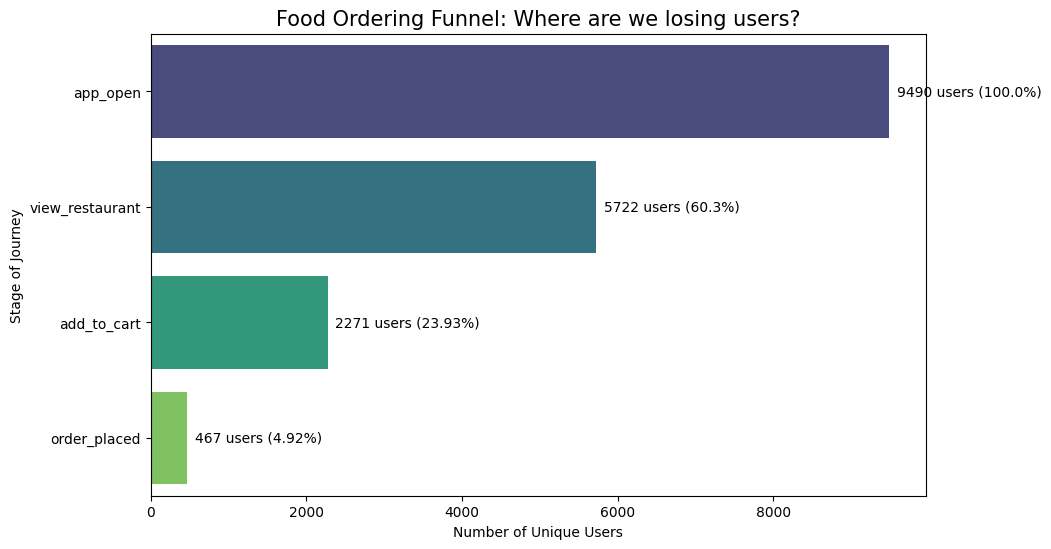

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Using the funnel_counts dataframe from Step 3
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='user_count', y='stage', data=funnel_counts, palette='viridis')

# Add labels to the bars
for i, v in enumerate(funnel_counts['user_count']):
    ax.text(v + 100, i, f"{v} users ({funnel_counts['conversion_rate'].iloc[i]}%)", color='black', va='center')

plt.title('Food Ordering Funnel: Where are we losing users?', fontsize=15)
plt.xlabel('Number of Unique Users')
plt.ylabel('Stage of Journey')
plt.show()